# Redes Neurais Convolucionais

**Objetivo**: construir uma rede neural convolucional simples para realizar a classificação entre imagens de gatos e de cachorros.

In [34]:
import os
import warnings
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# ignorar os warnings
warnings.filterwarnings('ignore')

In [2]:
# conectar colab no google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# definindo algumas constantes
DATA_PATH = '/content/drive/MyDrive/Bootcamp_DataScience/DeepLearningTensorflow/data/dataset'
TRAIN_PATH = os.path.join(DATA_PATH, 'training_set')
TEST_PATH = os.path.join(DATA_PATH, 'test_set')
BATCH_SIZE = 64
IMG_STD_SIZE = 128

In [4]:
# vamos analisar o que temos de imagens
len(os.listdir(os.path.join(TRAIN_PATH, 'dogs')))

4001

In [5]:
# construir uma função que mostre 4 imagens aleatórias de gatos
# e cachorros
def look_to_images():

  # amostrar 2 imagens de cãe e 2 de gatos
  dogs = np.random.choice(os.listdir(os.path.join(TRAIN_PATH, 'dogs')), 2)
  cats = np.random.choice(os.listdir(os.path.join(TRAIN_PATH, 'cats')), 2)

  # carregar e mostrar a imagem - cachorros
  fig = plt.figure(figsize=(15, 15))
  for i in range(2):

    img = image.load_img(os.path.join(TRAIN_PATH, 'dogs', dogs[i]))

    ax = fig.add_subplot(2, 2, i+1)
    plt.imshow(img)

  # carregar e mostrar a imagem - gatos
  for i in range(2):

    img = image.load_img(os.path.join(TRAIN_PATH, 'cats', cats[i]))

    ax = fig.add_subplot(2, 2, i+3)
    plt.imshow(img)


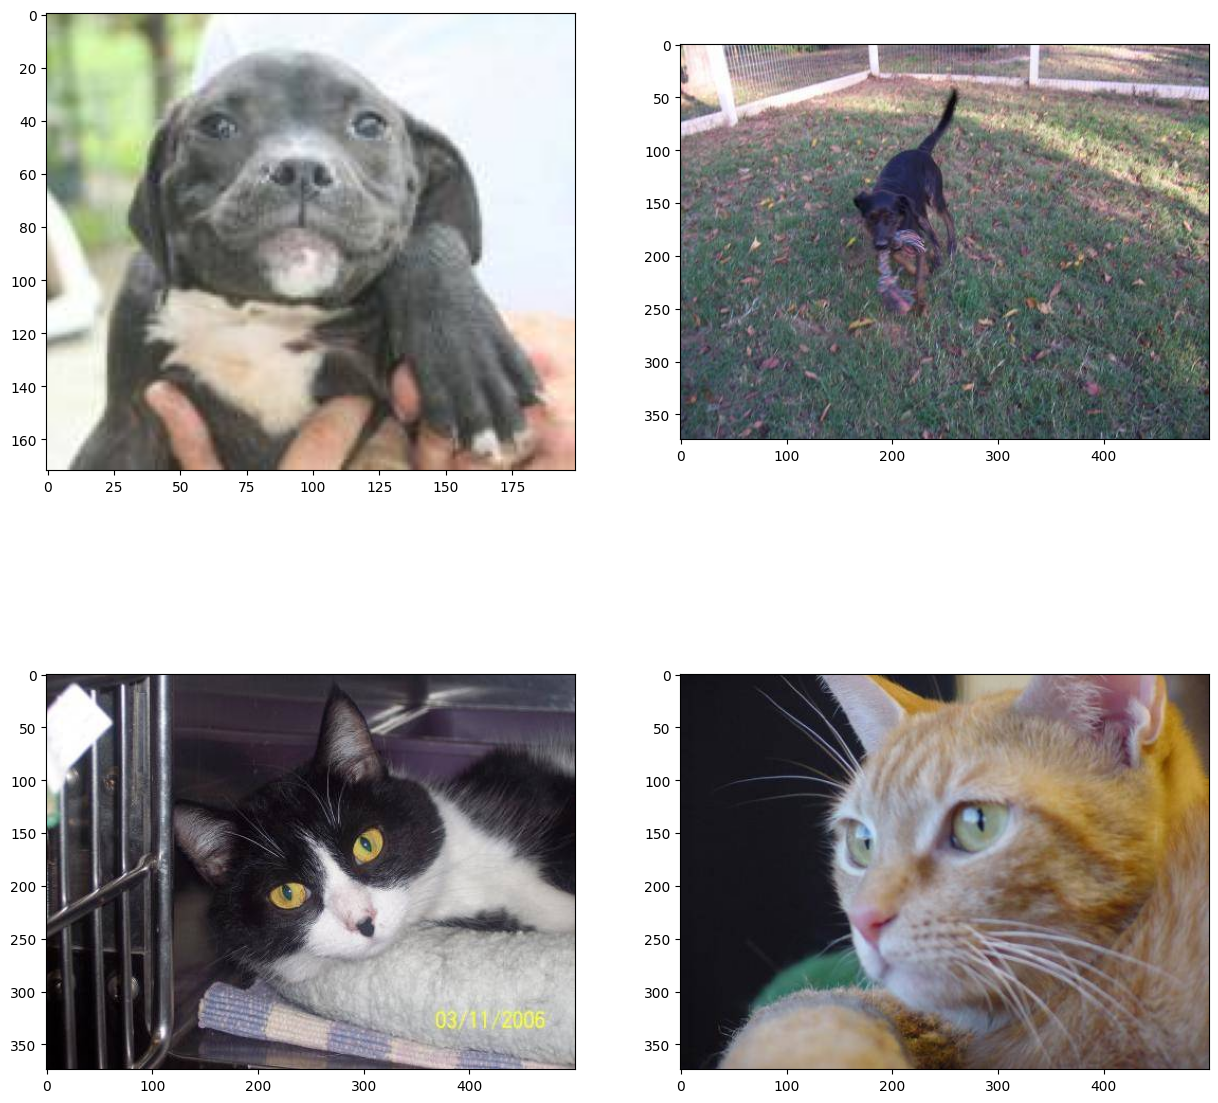

In [6]:
# verificando amostras de imagens
look_to_images()

## Criando Pré-processadores de Imagens

In [7]:
# criando um data augmentation para base de treinamento
train_datagen = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# para a base de teste, vamos apenas padronizar os pixels
test_datagen = ImageDataGenerator(
    rescale=1/255
)

In [8]:
# vamos construir DataLoaders (carregar imagens pouco a pouco na memória)
train_set = train_datagen.flow_from_directory(
    directory=TRAIN_PATH,
    target_size=(IMG_STD_SIZE, IMG_STD_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_set = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMG_STD_SIZE, IMG_STD_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Classe Construtora da CNN

In [9]:
# classe que define a CNN
class ConvolutionalNeuralNetwork:

  KERNEL_SIZE = 3         # tamanho do filtro de detector de atributos
  POOLING_SIZE = 2        # tamanho do pooling (agregador)
  POOLING_STRIDE = 2      # tamanho do passo do agregador

  def __init__(self, conv_list: list, neurons_list: list) -> None:

    # conv_list = camadas convolucionais (Conv + ReLU + Pooling)
    self.conv_list = conv_list

    # neurons_list = camadas totalmente conectadas (MLP)
    self.neurons_list = neurons_list

    # inicializar o modelo
    self.cnn_model = Sequential()

  def build_model(self, show_model: bool=False) -> None:

    # adicionar as camadas convolucionais
    # (Convolução + Polling + Flatten)
    self.add_convolutional_layers()

    # adiciono as camadas totalmente conectadas (MLP)
    self.add_fully_connected_layers()

    # mostrar arquitetura, se desejado
    if show_model:
      print(self.cnn_model.summary())

  def add_convolutional_layers(self) -> None:

    for conv in self.conv_list:
      # adicionando camadas convolucionais
      if conv == self.conv_list[0]:
        self.cnn_model.add(Conv2D(
            filters=conv,
            kernel_size=self.KERNEL_SIZE,
            activation='relu',
            input_shape=[IMG_STD_SIZE, IMG_STD_SIZE, 3]
        ))
      else:
        self.cnn_model.add(Conv2D(
            filters=conv,
            kernel_size=self.KERNEL_SIZE,
            activation='relu'
        ))

      # adicionar camadas de pooling (agregador)
      self.cnn_model.add(MaxPool2D(
          pool_size=self.POOLING_SIZE,
          strides=self.POOLING_STRIDE
      ))

    # adicionar uma camada Flatten
    self.cnn_model.add(Flatten())

  def add_fully_connected_layers(self) -> None:

    # adicionar camadas totalmente conectadas (MLP)
    for n in self.neurons_list:
        self.cnn_model.add(Dense(
            units=n,
            activation='relu'
        ))

    # adicionar uma camada final de classificação
    self.cnn_model.add(Dense(
        units=1,
        activation='sigmoid'
    ))

  def compile_model(self) -> None:

    # compilar o modelo para deixá-lo
    # pronto para o treinamento
    self.cnn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

  def fit_model(self, train_set, test_set, n_epochs: int=300) -> None:

    # save parameters
    self.N_EPOCHS = n_epochs

    # compilar o modelo
    self.compile_model()

    # iniciando o treinamento da rede
    self.history = self.cnn_model.fit(
        x=train_set,
        validation_data=test_set,
        epochs=n_epochs
    )

  def plot_history(self):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['accuracy'], label='Treinamento')
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['val_accuracy'], label='Teste')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel('Acurácia')
    plt.title(f'Curva de Aprendizado - Acurácia')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['loss'], label='Treinamento')
    plt.plot(range(1, self.N_EPOCHS+1), self.history.history['val_loss'], label='Teste')
    plt.legend(loc='best')
    plt.xlabel('Número de Épocas')
    plt.ylabel('Função de Perda')
    plt.title('Curva de Aprendizado - Função de Perda')
    plt.show()

In [ ]:
# testando nossa CNN
cnn = ConvolutionalNeuralNetwork(
    conv_list=[32, 32],
    neurons_list=[500, 250]
)
cnn.build_model(show_model=True)
cnn.fit_model(
    train_set=train_set,
    test_set=test_set,
    n_epochs=50
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 28800)             0         
                                                                 
 dense_13 (Dense)            (None, 500)              

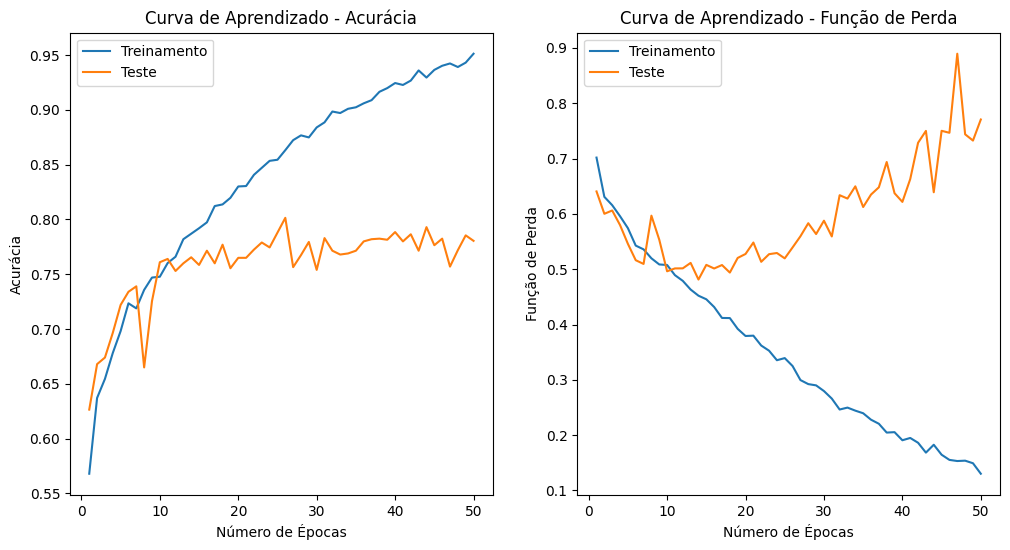

In [ ]:
cnn.plot_history()

In [ ]:
# serialize model to JSON
model_json = cnn.cnn_model.to_json()
with open(os.path.join(DATA_PATH, 'models', "model_c32_c32_500_250_img64.json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.cnn_model.save_weights(os.path.join(DATA_PATH, 'models', "model_c32_c32_500_250_img64.h5"))

In [60]:
# listar o diretório de modelos
models_dir_list = os.listdir(os.path.join(DATA_PATH, 'models'))

# filtrar apenas os arquivos json e extrair nomes de modelos
models_dir_list = [f.split('.')[0] for f in models_dir_list if f.find('json') != -1]

# carregar o modelo em json e os pesos em h5
for model_name in models_dir_list:
  with open(os.path.join(DATA_PATH, 'models', f'{model_name}.json'), 'r') as f:
    model_text = f.read()

  model = model_from_json(model_text)
  model.load_weights(os.path.join(DATA_PATH, 'models', f'{model_name}.h5'))

  # compilação do modelo
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

  # realizar a geração das imagens
  if model_name.find('img64') != -1:
    test_set = test_datagen.flow_from_directory(
        directory=TEST_PATH,
        target_size=(128, 128),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
  else:
    test_set = test_datagen.flow_from_directory(
        directory=TEST_PATH,
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

  # realizar a avaliação dos modelos
  loss, acc = model.evaluate(test_set)

  print(model_name)
  print(f'Acurácia (Base de Teste): {round(acc * 100, 0)} %')

Found 2000 images belonging to 2 classes.
32/32 [==============================] - 9s 252ms/step - loss: 0.4947 - accuracy: 0.7775
model_c32_c32_150
Acurácia (Base de Teste): 78.0 %
Found 2000 images belonging to 2 classes.
32/32 [==============================] - 8s 241ms/step - loss: 0.4832 - accuracy: 0.8010
model_c32_c32_c32_500_250
Acurácia (Base de Teste): 80.0 %
Found 2000 images belonging to 2 classes.
32/32 [==============================] - 11s 307ms/step - loss: 0.7063 - accuracy: 0.7725
model_c64_c64_500_250
Acurácia (Base de Teste): 77.0 %
Found 2000 images belonging to 2 classes.
32/32 [==============================] - 19s 573ms/step - loss: 0.7705 - accuracy: 0.7805
model_c32_c32_500_250_img64
Acurácia (Base de Teste): 78.0 %
